### EDA on Evidence Objects (from ES)

In [1]:
import glob
import os.path as osp
import tqdm
import json
import pandas as pd
import numpy as np
import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt
import plotnine as pn
data_file = '/lab/data/raw/evidence-data-stage-2.parquet'
sample_file = '/lab/data/raw/evidence-data-stage-2.sample.csv'

In [2]:
# dask.config.set(scheduler='synchronous') # debugging
dask.config.set(scheduler='processes', num_workers=3) # conservative settings (minimal interruption)
# dask.config.set(scheduler='processes') # activate when ready (i.e. more RAM, more cores)

## Generate Sample 

Randomly select a subset of data to analyze for now and reload that sample in a new kernel:

In [4]:
# Load individual records from ES export
df = dd.read_parquet(data_file)

In [5]:
df

,access_level,disease,drug,evidence,id,literature,private,scores,sourceID,target,type,unique_association_fields,validated_against_schema_version,batch
npartitions=163,,,,,,,,,,,,,,
,object,object,object,object,object,object,object,object,object,object,object,object,object,category[known]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [6]:
# Downsample to size large enough for laptop but
# continue analysis with out-of-core assumption
#df = df.sample(frac=.05, random_state=1).compute()
df = df.sample(frac=.2, random_state=1).compute()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325309 entries, 8450 to 3856
Data columns (total 14 columns):
access_level                        325309 non-null object
disease                             325309 non-null object
drug                                325309 non-null object
evidence                            325309 non-null object
id                                  325309 non-null object
literature                          325309 non-null object
private                             325309 non-null object
scores                              325309 non-null object
sourceID                            325309 non-null object
target                              325309 non-null object
type                                325309 non-null object
unique_association_fields           325309 non-null object
validated_against_schema_version    325309 non-null object
batch                               325309 non-null category
dtypes: category(1), object(13)
memory usage: 35.4+ MB


In [7]:
# Drop even this tiny sample into some file to be loaded without
# using the same kernel as pyarrow as it has ridiculous memory leaks
df.to_csv(sample_file, index=False)
sample_file

'/lab/data/raw/evidence-data-stage-2.sample.csv'

## Initialize Data Source

In [79]:
# df = dd.read_parquet('/lab/data/raw/evidence-data-stage-2.parquet')
df = pd.read_csv(sample_file)
df['idx'] = np.arange(1, len(df) + 1)
df.info(memory_usage='deep')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325309 entries, 0 to 325308
Data columns (total 15 columns):
access_level                        325309 non-null object
disease                             325309 non-null object
drug                                76646 non-null object
evidence                            325309 non-null object
id                                  325309 non-null object
literature                          88608 non-null object
private                             325309 non-null object
scores                              325309 non-null object
sourceID                            325309 non-null object
target                              325309 non-null object
type                                325309 non-null object
unique_association_fields           325309 non-null object
validated_against_schema_version    284464 non-null object
batch                               325309 non-null int64
idx                                 325309 non-null int64
dtypes: 

In [80]:
df = dd.from_pandas(df, npartitions=15) 

In [81]:
df

,access_level,disease,drug,evidence,id,literature,private,scores,sourceID,target,type,unique_association_fields,validated_against_schema_version,batch,idx
npartitions=15,,,,,,,,,,,,,,,
0,object,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64
21688,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303632,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325308,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [86]:
# Ensure ids are really unique before continuing
assert df['id'].value_counts().max().compute() == 1

## Stats

In [6]:
len(df)

325309

In [7]:
df['sourceID'].value_counts().compute()

phenodigm             100202
chembl                 76646
expression_atlas       40845
gwas_catalog           36180
eva                    19352
slapenrich             14935
cancer_gene_census     12052
phewas_catalog         11123
uniprot                 6118
genomics_england        2130
reactome                2007
eva_somatic             1502
uniprot_literature       900
intogen                  473
crispr                   332
gene2phenotype           310
sysbio                    89
uniprot_somatic           57
progeny                   56
Name: sourceID, dtype: int64

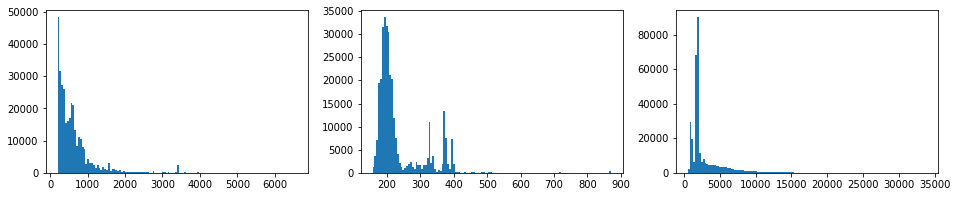

In [8]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(16, 3)
ax[0].hist(df['disease'].str.len().compute(), bins=128)
ax[1].hist(df['target'].str.len().compute(), bins=128)
ax[2].hist(df['evidence'].str.len().compute(), bins=128)
None

### Disease

In [9]:
# Example record
print(json.dumps(json.loads(df['disease'].head(1).iloc[0]), indent=2))

{
  "biosample": {
    "id": "http://purl.obolibrary.org/obo/UBERON_0000178",
    "name": "peripheral blood"
  },
  "efo_info": {
    "efo_id": "http://www.ebi.ac.uk/efo/EFO_0004249",
    "label": "meningococcal infection",
    "path": [
      [
        "EFO_0000408",
        "EFO_0005741",
        "EFO_0000771",
        "EFO_0004249"
      ]
    ],
    "therapeutic_area": {
      "codes": [],
      "labels": []
    }
  },
  "id": "EFO_0004249"
}


In [10]:
def from_json(v):
    try:
        return json.loads(v)
    except:
        return None

In [11]:
def get_labels(v):
    v = from_json(v)
    if v is None:
        return ''
    if 'efo_info' in v and 'therapeutic_area' in v['efo_info']:
        return ':'.join(sorted(v['efo_info']['therapeutic_area']['labels']))
    return 'NA'
df['disease'].apply(get_labels, meta='foo').value_counts().compute()

    325309
dtype: int64

In [12]:
def get_path_len(v):
    v = from_json(v)
    if v is None:
        return np.nan
    if 'efo_info' in v and 'path' in v['efo_info']:
        return max([len(p) for p in v['efo_info']['path']])
    return np.nan
df['disease'].apply(get_path_len, meta=1).value_counts().compute().sort_index()

1         1
2      6388
3     26703
4     48412
5     60916
6     58749
7     47474
8     34686
9     31836
10     5310
11     3854
12      794
13      186
dtype: int64

### Evidence

In [13]:
# Example record
print(json.dumps(json.loads(df['evidence'].head(1).iloc[0]), indent=2))

{
  "comparison_name": "'monocyte; meningococcal sepsis' at '24 hour' vs 'monocyte; normal' at '0 hour'",
  "confidence_level": "medium",
  "date_asserted": "2015-08-28T05:30:30Z",
  "evidence_codes": [
    "ECO_0000058"
  ],
  "evidence_codes_info": [
    [
      {
        "eco_id": "ECO_0000058",
        "label": "expression microarray evidence"
      }
    ]
  ],
  "experiment_overview": "Transcription profiling by array of human peripheral blood cells from meningococcal sepsis patients sampled at various time points",
  "is_associated": true,
  "log2_fold_change": {
    "percentile_rank": 98,
    "value": -1.2
  },
  "organism_part": "http://purl.obolibrary.org/obo/UBERON_0000178",
  "provenance_type": {
    "database": {
      "id": "Expression_Atlas",
      "version": "prod.30"
    }
  },
  "reference_replicates_n": 3,
  "reference_sample": "monocyte; 0 hour; normal",
  "resource_score": {
    "method": {
      "description": "Moderated <i>t</i>-statistics computed with <a href=\

In [63]:
# Get unique sets of keys at top level of evidence object
def get_evidence_keys(v):
    ev = from_json(v)
    if ev is None:
        return ''
    return ', '.join(sorted(list(ev.keys())))
pd.set_option('display.max_colwidth', 100)
df['evidence'].apply(get_evidence_keys, meta=str).value_counts().compute()\
    .rename_axis('keys').rename('count').reset_index()

,keys,count
0,"biological_model, disease_model_association, evidence_codes, evidence_codes_info, orthologs",100202
1,"drug2clinic, evidence_codes, evidence_codes_info, target2drug",76646
2,"evidence_codes, evidence_codes_info, gene2variant, variant2disease",72773
3,"comparison_name, confidence_level, date_asserted, evidence_codes, evidence_codes_info, experimen...",40845
4,"date_asserted, evidence_codes, evidence_codes_info, is_associated, provenance_type, resource_sco...",18331
5,"date_asserted, evidence_codes, evidence_codes_info, is_associated, known_mutations, provenance_t...",14589
6,"clinical_significance, date_asserted, evidence_codes, evidence_codes_info, is_associated, known_...",1502
7,"date_asserted, evidence_codes, evidence_codes_info, is_associated, provenance_type, resource_score",421


In [87]:
# Fetch resource scores (i.e. evidence string scores) by source and type
# noting that there may be multiple for a single evidence record
def get_resource_scores(r):
    src = r['sourceID']
    ev = from_json(r['evidence'])
    if ev is None:
        return pd.DataFrame({'src': [src]}).assign(idx=None, key=None, score=None, type=None)
    df = []
    for k in ev.keys():
        if isinstance(ev[k], dict) and 'resource_score' in ev[k]:
            score = ev[k]['resource_score']
            df.append({'idx': r['idx'], 'key': k, 'score': score['value'], 'type': score['type']})
    return pd.DataFrame(df).assign(src=src)

def get_resource_scores_df(df):
    return pd.concat([
        get_resource_scores(r) 
        for _, r in df.iterrows()
    ], sort=True)

dfrsc = df.map_partitions(get_resource_scores_df).compute()
dfrsc.head()

,idx,key,score,src,type
0,38156.0,drug2clinic,0.2,chembl,probability
1,38156.0,target2drug,1.0,chembl,probability
0,39215.0,drug2clinic,1.0,chembl,probability
1,39215.0,target2drug,1.0,chembl,probability
0,39319.0,drug2clinic,1.0,chembl,probability


In [88]:
dfrsc.groupby(['src', 'key', 'type']).size()

src             key                        type        
chembl          drug2clinic                probability      76646
                target2drug                probability      76646
eva             gene2variant               probability      19352
                variant2disease            pvalue           19352
gwas_catalog    gene2variant               probability      36180
                variant2disease            pvalue           36180
phenodigm       biological_model           probability     100202
                disease_model_association  summed_total    100202
                orthologs                  probability     100202
phewas_catalog  gene2variant               probability      11123
                variant2disease            pvalue           11123
uniprot         gene2variant               probability       6118
                variant2disease            probability       6118
dtype: int64

In [89]:
# Show resource score summaries
dfrsc.groupby(['src', 'key', 'type'])['score'].describe().round(2)

count  mean   std  \
src            key                       type                                 
chembl         drug2clinic               probability    76646.0  0.49  0.37   
               target2drug               probability    76646.0  1.00  0.00   
eva            gene2variant              probability    19352.0  0.85  0.12   
               variant2disease           pvalue         19352.0  0.00  0.00   
gwas_catalog   gene2variant              probability    36180.0  0.60  0.08   
               variant2disease           pvalue         36180.0  0.00  0.00   
phenodigm      biological_model          probability   100202.0  1.00  0.00   
               disease_model_association summed_total  100202.0  0.96  0.04   
               orthologs                 probability   100202.0  1.00  0.00   
phewas_catalog gene2variant              probability    11123.0  0.50  0.00   
               variant2disease           pvalue         11123.0  0.02  0.01   
uniprot        gene2variant              probability     6118.0  0.70  0.00   
               variant2disease           probability     6118.0  1.00  0.05   

                                                        min   25%   50%   75%  \
src            key                       type                                   
chembl         drug2clinic               probability   0.09  0.20  0.20  1.00   
               target2drug               probability   1.00  1.00  1.00  1.00   
eva            gene2variant              probability   0.50  0.70  0.95  0.95   
               variant2disease           pvalue        0.00  0.00  0.00  0.00   
gwas_catalog   gene2variant              probability   0.50  0.50  0.65  0.65   
               variant2disease           pvalue        0.00  0.00  0.00  0.00   
phenodigm      biological_model          probability   1.00  1.00  1.00  1.00   
               disease_model_association summed_total  0.90  0.93  0.96  1.00   
               orthologs                 probability   1.00  1.00  1.00  1.00   
phewas_catalog gene2variant              probability   0.50  0.50  0.50  0.50   
               variant2disease           pvalue        0.00  0.01  0.02  0.04   
uniprot        gene2variant              probability   0.70  0.70  0.70  0.70   
               variant2disease           probability   0.50  1.00  1.00  1.00   

                                                        max  
src            key                       type                
chembl         drug2clinic               probability   1.00  
               target2drug               probability   1.00  
eva            gene2variant              probability   1.00  
               variant2disease           pvalue        0.00  
gwas_catalog   gene2variant              probability   0.95  
               variant2disease           pvalue        0.00  
phenodigm      biological_model          probability   1.00  
               disease_model_association summed_total  1.00  
               orthologs                 probability   1.00  
phewas_catalog gene2variant              probability   0.50  
               variant2disease           pvalue        0.05  
uniprot        gene2variant              probability   0.70  
               variant2disease           probability   1.00

#### Resource score distributions

/usr/local/lib/python3.7/site-packages/mizani/bounds.py:443: RuntimeWarning: overflow encountered in double_scalars
  return np.abs((x[0] - x[1]) / m) < tol


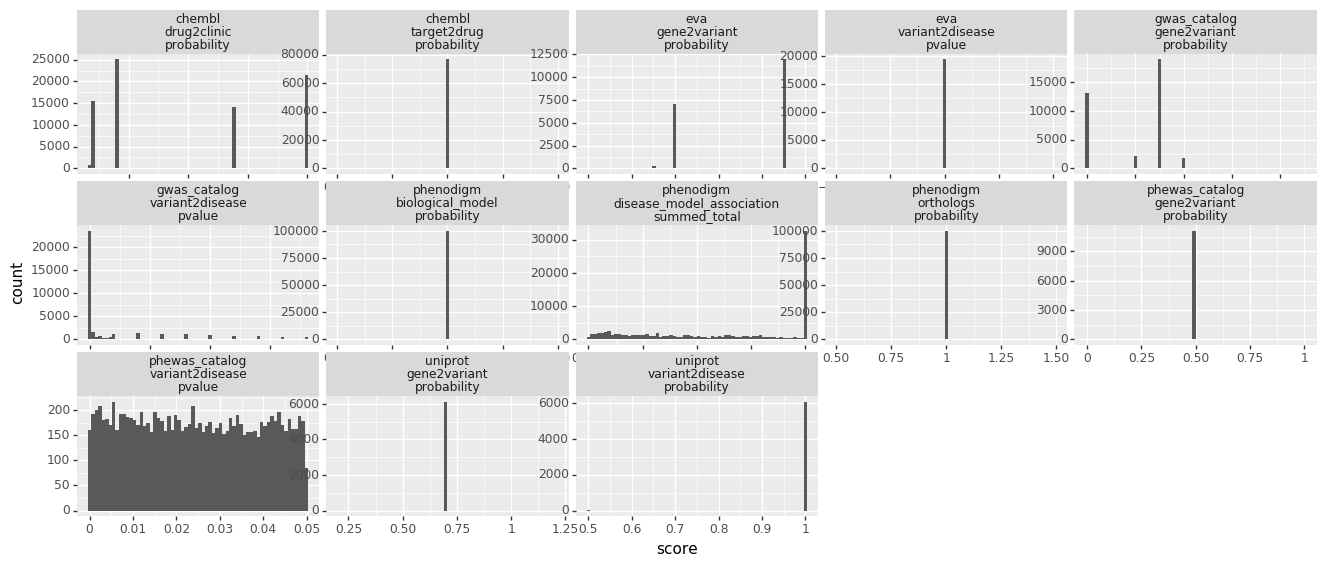

<ggplot: (8786631361629)>

In [67]:
# Show resource scores by source and score type to see how often they are simply mapped 
# from categorical values (which should be obvious with low cardinality histograms)
(
    pn.ggplot(dfrsc, pn.aes(x='score')) + 
    pn.facet_wrap('~src + key + type', scales='free', ncol=5) + 
    pn.geom_histogram(bins=64) +
    pn.theme(figure_size=(16,6))
)

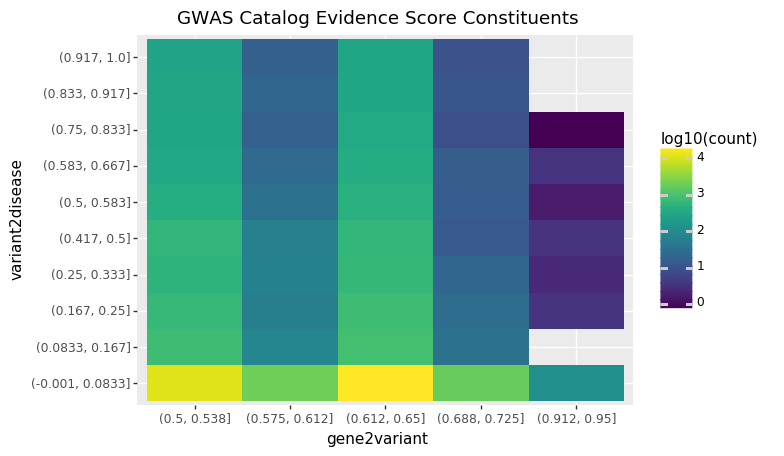

<ggplot: (8786617510249)>

In [112]:
(
    dfrsc
    .pipe(lambda df: df[df['key'].isin(['variant2disease', 'gene2variant'])])
    .pipe(lambda df: df[df['src'] == 'gwas_catalog'])
    .pipe(lambda df: df[df['idx'].notnull()])
    .assign(idx=lambda df: df['idx'].astype(int))
    .pivot(index='idx', columns='key', values='score').reset_index()
    .assign(variant2disease=lambda df: df['variant2disease'] / df['variant2disease'].max())
    .assign(v2d=lambda df: pd.cut(df['variant2disease'], 12))
    .assign(g2v=lambda df: pd.cut(df['gene2variant'], 12))
    .groupby(['g2v', 'v2d']).size().rename('count').reset_index()
    .assign(count=lambda df: df['count'].apply(np.log10))
    .pipe(lambda df: 
        pn.ggplot(df, pn.aes(x='g2v', y='v2d', fill='count')) +
        pn.geom_tile() + 
        pn.labs(
            x='gene2variant', y='variant2disease', 
            title='GWAS Catalog Evidence Score Constituents',
            fill='log10(count)'
        )
    )
)

### Drug

In [21]:
df[df['drug'].notnull()]['sourceID'].value_counts().compute()

chembl    76646
Name: sourceID, dtype: int64

In [35]:
dfrx = df[df['drug'].notnull()].compute()

In [119]:
# Example record
print(json.dumps(json.loads(dfrx['drug'].head(1).iloc[0]), indent=2))
print('--')
print(json.dumps(json.loads(dfrx['target'].head(1).iloc[0]), indent=2))

{
  "id": "http://identifiers.org/chembl.compound/CHEMBL803",
  "molecule_name": "CYTARABINE",
  "molecule_type": "Small molecule"
}
--
{
  "activity": "negative_modulator",
  "binding_subunit_known": false,
  "complex_id": "CHEMBL2363042",
  "gene_info": {
    "geneid": "ENSG00000100479",
    "name": "DNA polymerase epsilon 2, accessory subunit",
    "symbol": "POLE2"
  },
  "id": "ENSG00000100479",
  "target_class": [
    "Enzyme",
    "Transferase",
    "Unclassified protein"
  ],
  "target_name": "DNA polymerase (alpha/delta/epsilon)",
  "target_type": "protein_family"
}


In [41]:
meta = {'drug_id': str, 'drug_name': str, 'target': str}
def get_drug_target(r):
    target = from_json(r['target'])
    drug = from_json(r['drug'])
    if target is None or drug is None:
        return pd.Series({k: None for k in meta.keys()})
    return pd.Series({'drug_id': drug['id'], 'drug_name': drug['molecule_name'], 'target': target['id']})
dfrt = dd.from_pandas(dfrx, npartitions=1).apply(get_drug_target, axis=1, meta=meta).compute()
dfrt.head()

,drug_id,drug_name,target
38155,http://identifiers.org/chembl.compound/CHEMBL803,CYTARABINE,ENSG00000100479
39214,http://identifiers.org/chembl.compound/CHEMBL660,AMANTADINE,ENSG00000273079
39318,http://identifiers.org/chembl.compound/CHEMBL660,AMANTADINE,ENSG00000198785
40000,http://identifiers.org/chembl.compound/CHEMBL635,PREDNISONE,ENSG00000113580
40001,http://identifiers.org/chembl.compound/CHEMBL3...,OSIMERTINIB,ENSG00000178568


#### Drugs with highest number of targets

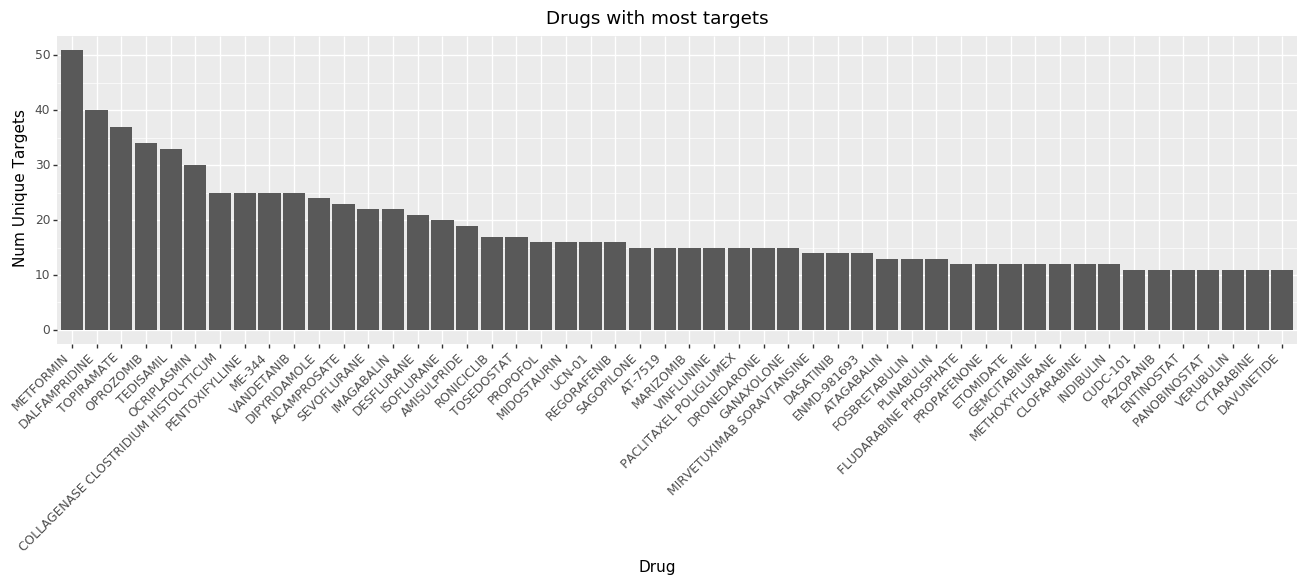

<ggplot: (8786583299001)>

In [176]:
assert dfrt.groupby(['drug_id'])['drug_name'].nunique().max() == 1
(
    pn.ggplot(
        dfrt.groupby(['drug_id', 'drug_name'])['target'].nunique().rename('count')
        .sort_values().tail(50).reset_index()
        .assign(drug_name=lambda df: pd.Categorical(
            df['drug_name'], ordered=True,
            categories=df.sort_values('count')['drug_name'][::-1]
        )),
        pn.aes(x='drug_name', y='count')
    ) + 
    pn.geom_bar(stat='identity') + 
    pn.labs(x='Drug', y='Num Unique Targets', title='Drugs with most targets') + 
    pn.theme(figure_size=(16, 4), axis_text_x=pn.element_text(rotation=45, hjust=1))
)

### Target

In [121]:
# Example record
print(json.dumps(json.loads(df['target'].head(1).iloc[0]), indent=2))
print('--')
print(json.dumps(json.loads(df['disease'].head(1).iloc[0]), indent=2))

{
  "activity": "decreased_transcript_level",
  "gene_info": {
    "geneid": "ENSG00000182162",
    "name": "P2Y receptor family member 8",
    "symbol": "P2RY8"
  },
  "id": "ENSG00000182162",
  "target_type": "transcript_evidence"
}
--
{
  "biosample": {
    "id": "http://purl.obolibrary.org/obo/UBERON_0000178",
    "name": "peripheral blood"
  },
  "efo_info": {
    "efo_id": "http://www.ebi.ac.uk/efo/EFO_0004249",
    "label": "meningococcal infection",
    "path": [
      [
        "EFO_0000408",
        "EFO_0005741",
        "EFO_0000771",
        "EFO_0004249"
      ]
    ],
    "therapeutic_area": {
      "codes": [],
      "labels": []
    }
  },
  "id": "EFO_0004249"
}


In [129]:
# Find targets with most diseases
meta = {
    'target_id': str, 'target_type': str, 'target_symbol': str, 
    'disease_id': str, 'disease_name': str, 'source': str
}
res_na = pd.Series({k: None for k in meta.keys()})
def get_target_disease(r):
    target = from_json(r['target'])
    disease = from_json(r['disease'])
    if target is None or disease is None:
        return res_na
    if 'efo_info' not in disease or 'gene_info' not in target:
        return res_na
    return pd.Series({
        'target_id': target['id'], 'target_type': target['target_type'], 
        'target_symbol': target['gene_info']['symbol'], 
        'disease_id': disease['id'], 
        'disease_name': disease['efo_info']['label'],
        'source': r['sourceID']
    })
dftd = df.apply(get_target_disease, axis=1, meta=meta).compute()
dftd.head()

,target_id,target_type,target_symbol,disease_id,disease_name,source
0,ENSG00000182162,transcript_evidence,P2RY8,EFO_0004249,meningococcal infection,expression_atlas
1,ENSG00000085276,transcript_evidence,MECOM,EFO_1000796,adrenal cortex carcinoma,expression_atlas
2,ENSG00000139832,transcript_evidence,RAB20,EFO_0004249,meningococcal infection,expression_atlas
3,ENSG00000161281,transcript_evidence,COX7A1,EFO_0000305,breast carcinoma,expression_atlas
4,ENSG00000143476,transcript_evidence,DTL,EFO_0000729,ulcerative colitis,expression_atlas


In [130]:
dftd['target_type'].value_counts()

gene_evidence                  177882
transcript_evidence             40845
protein_family                  23793
single_protein                  21498
gene_variant                    20854
protein_complex_group           16658
protein_complex                 14626
protein_evidence                 9082
selectivity_group                  57
nucleic_acid                        7
chimeric_protein                    4
protein_protein_interaction         3
Name: target_type, dtype: int64

In [131]:
dftd['source'].value_counts()

phenodigm             100202
chembl                 76646
expression_atlas       40845
gwas_catalog           36180
eva                    19352
slapenrich             14935
cancer_gene_census     12052
phewas_catalog         11123
uniprot                 6118
genomics_england        2130
reactome                2007
eva_somatic             1502
uniprot_literature       900
intogen                  473
crispr                   332
gene2phenotype           310
sysbio                    89
uniprot_somatic           57
progeny                   56
Name: source, dtype: int64

In [136]:
assert dftd.groupby('disease_id')['disease_name'].nunique().max() == 1
assert dftd.groupby('target_id')['target_symbol'].nunique().max() == 1

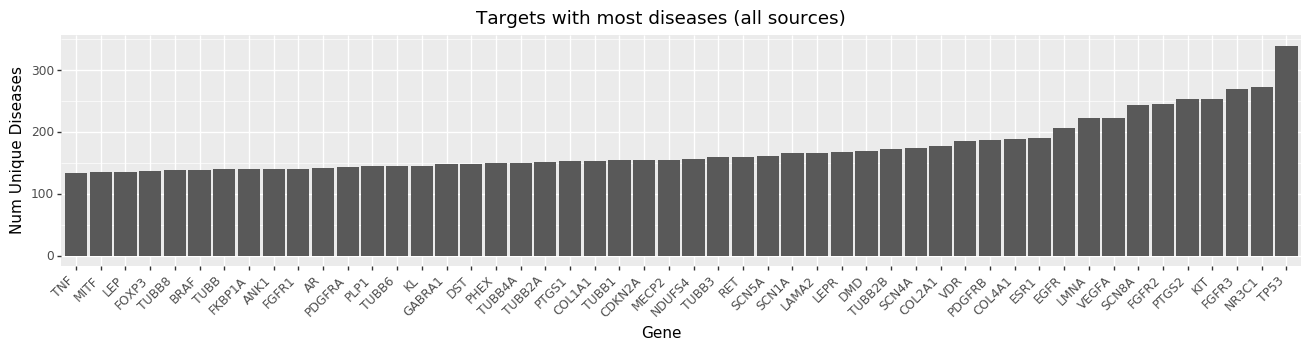

<ggplot: (8786590311037)>

In [178]:
def plot_frequent_targets(df):
    return (
        df
        .groupby(['target_id', 'target_symbol'])['disease_id'].nunique()
        .rename('count').reset_index()
        .sort_values('count').tail(50)
        .assign(target_symbol=lambda df: pd.Categorical(
            df['target_symbol'], ordered=True,
            categories=df.groupby('target_symbol')['count'].max().sort_values().index
        ))
        .pipe(lambda df: 
            pn.ggplot(df, pn.aes(x='target_symbol', y='count')) + 
            pn.geom_bar(stat='identity') +
            pn.labs(x='Gene', y='Num Unique Diseases') + 
            pn.theme(figure_size=(16, 3), axis_text_x=pn.element_text(rotation=45, hjust=1))
        )
    )
plot_frequent_targets(dftd) + pn.labs(title='Targets with most diseases (all sources)')

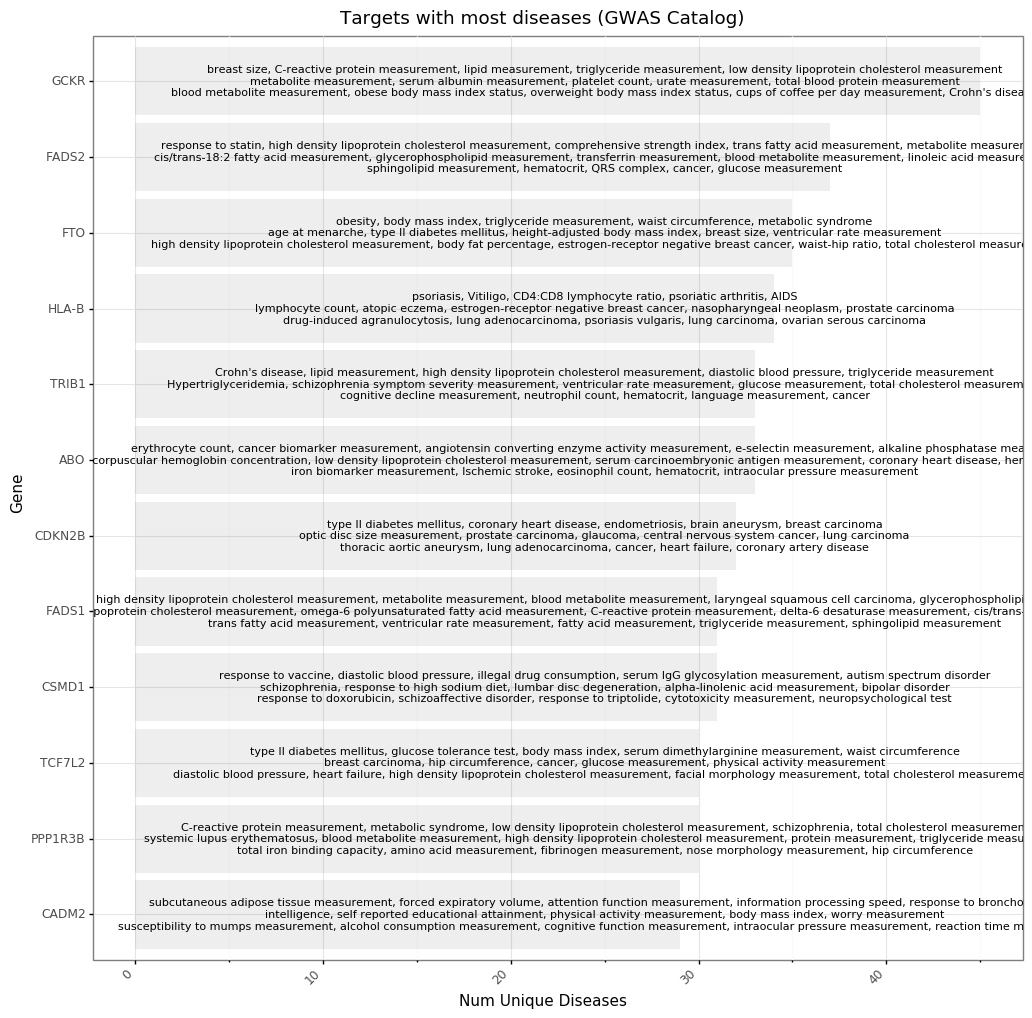

<ggplot: (8786590555457)>

In [177]:
import more_itertools

def get_label(diseases):
    return '\n'.join([', '.join(b) for b in more_itertools.chunked(diseases[:15], 5)])

def plot_frequent_targets_with_disease(df):
    return (
        df
        .groupby(['target_id', 'target_symbol'])
        .agg({'disease_id': 'nunique', 'disease_name': 'unique'})
        .rename(columns={'disease_id': 'count'}).reset_index()
        .sort_values('count').tail(12)
        .assign(target_symbol=lambda df: pd.Categorical(
            df['target_symbol'], ordered=True,
            categories=df.groupby('target_symbol')['count'].max().sort_values().index
        ))
        .assign(label=lambda df: df['disease_name'].apply(get_label))
        .pipe(lambda df: 
            pn.ggplot(df, pn.aes(x='target_symbol', y='count', label='label')) + 
            pn.geom_bar(stat='identity', alpha=.1) +
            pn.geom_text(mapping=pn.aes(y=25), angle=0, size=8) + 
            pn.coord_flip() + 
            pn.labs(x='Gene', y='Num Unique Diseases') + 
            pn.theme_bw() + 
            pn.theme(figure_size=(12, 12), axis_text_x=pn.element_text(rotation=45, hjust=1))
        )
    )

plot_frequent_targets_with_disease(dftd.pipe(lambda df: df[df['source'] == 'gwas_catalog'])) + \
    pn.labs(title='Targets with most diseases (GWAS Catalog)')